# MANUTENÇÃO PREDITIVA: ESTUDO DE CASO

## INTERPRETAÇÃO DO PROBLEMA:

### O conjunto de dados refere-se a um único equipamento, aonde para cada ciclo temos as medições das outras variáveis: temperatura, pressão, vibração em x,y,z, frequência etc, e se ocorreu falha para esses dados, o atributo ciclo poderia representar a variável temporal, nesse caso o problema poderia ser modelado utilizando séries temporais, mas decidi iniciar com uma abordagem mais simples, o problema de negócio da empresa é um problema de manutenção preditiva, basicamente um problema de classificação, dessa forma o objetivo é prever se o equipamento irá falhar ou não para cada conjunto de variáveis preditoras em cada amostra, portanto o alvo é a variável Fail, e como as falhas são muito raras o problema em questão poderia ser tratado como um problema de detecção de outliers.

## Importa as Bibliotecas Necessárias

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, fbeta_score, recall_score, precision_score, confusion_matrix, make_scorer
from confusion_matrix_pretty_print import plot_confusion_matrix_from_data
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV,KFold
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,roc_auc_score, roc_curve, auc


%matplotlib inline

sns.set_style("whitegrid")

## Carrega os Dados

In [3]:
path='data/'

file = os.listdir(path)

In [4]:
df = pd.read_excel(path+file[0], header=0, sheet_name=None)
df=df['O&G Equipment Data']

## Exibe uma amostra dos dados

In [5]:
df.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


In [6]:
df.tail()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
795,796,2,6,50.469522,98.235421,151.585252,99.341380,148.838481,49.841400,True
796,797,1,4,49.985270,160.433640,110.953010,160.777175,109.917566,110.919290,True
797,798,1,4,79.777294,110.535405,61.334995,149.577811,129.463843,70.853353,True
798,799,2,8,79.360314,159.985443,61.762879,169.773831,130.213426,80.113540,True
799,800,3,1,80.854011,110.543701,121.032227,131.719473,90.331155,71.261717,True


## Exibe algumas informações referentes às colunas do DataFrame

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 57.2 KB


In [8]:
df.isnull().sum() # Não existem valores faltantes, e cada variável já está no tipo correto!!! conjunto de dados muito bom!!!

Cycle          0
Preset_1       0
Preset_2       0
Temperature    0
Pressure       0
VibrationX     0
VibrationY     0
VibrationZ     0
Frequency      0
Fail           0
dtype: int64

## Exibe algumas estatísticas referentes ao conjunto de dados

In [9]:
df.describe()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,1.988750,4.551250,69.263494,78.997945,73.860275,72.786878,71.866211,68.223449
std,231.0844,0.805875,2.293239,25.536252,32.501834,31.229631,32.739745,27.844616,29.138702
min,1.0000,1.000000,1.000000,2.089354,3.480279,3.846343,10.057744,18.784169,4.380101
25%,200.7500,1.000000,3.000000,51.040134,55.508564,50.752461,48.523982,50.787638,45.861762
50%,400.5000,2.000000,5.000000,65.906716,75.014848,69.394953,65.504770,69.319237,65.664252
75%,600.2500,3.000000,7.000000,80.527220,99.302530,90.195059,94.075572,88.891205,90.097457
max,800.0000,3.000000,8.000000,255.607829,189.995681,230.861142,193.569947,230.951134,178.090303


#### A maioria das váriaveis apresenta média muito próxima da mediana, o que é um bom indicativo que os dados seguem uma distribuição normal, isso também é ótimo, pois a maioria dos algoritimos de machine learning exigem isso!

### Verificando se o dataset está balanceado

In [10]:
df['Fail'].value_counts()

False    734
True      66
Name: Fail, dtype: int64

### O dataset está desbalanceado, poucas instâncias de falhas em relação ao total

## Análise Exploratória

In [11]:
color_fail=['white' if x==False else 'black' for x in df['Fail']] #descobrindo quando a falha ocorre

### Cycle x Preset_1

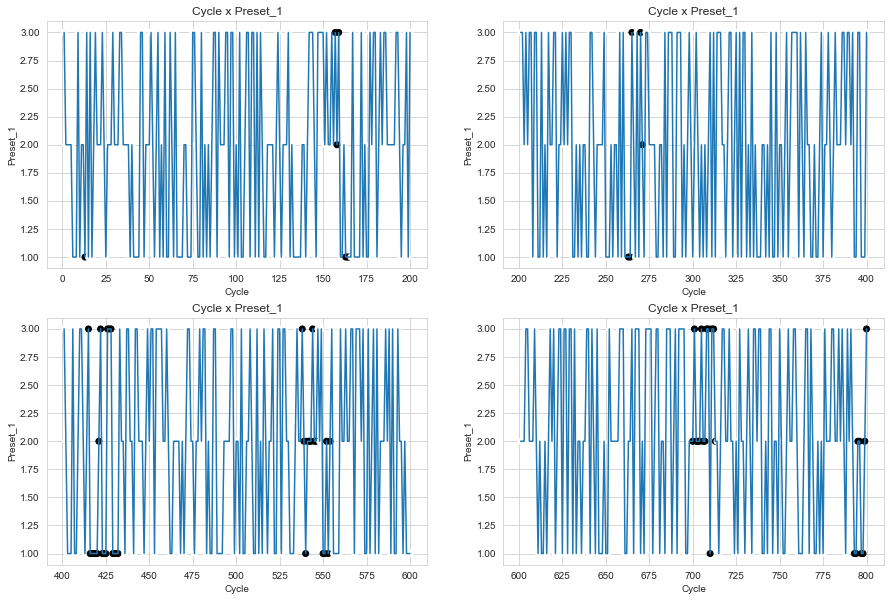

In [12]:
n1=200
n2=400
n3=600
n4=800

#plt.figure(figsize = (20,15))
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0, 0].set_title('Cycle x Preset_1')
ax[0, 0].set_xlabel('Cycle')
ax[0, 0].set_ylabel('Preset_1')
ax[0, 0].scatter(df['Cycle'][:n1],df['Preset_1'][:n1],c=color_fail[:n1])
ax[0, 0].plot(df['Cycle'][:n1],df['Preset_1'][:n1])

ax[0, 1].set_title('Cycle x Preset_1')
ax[0, 1].set_xlabel('Cycle')
ax[0, 1].set_ylabel('Preset_1')
ax[0, 1].scatter(df['Cycle'][n1:n2],df['Preset_1'][n1:n2],c=color_fail[n1:n2])
ax[0, 1].plot(df['Cycle'][n1:n2],df['Preset_1'][n1:n2])

ax[1, 0].set_title('Cycle x Preset_1')
ax[1, 0].set_xlabel('Cycle')
ax[1, 0].set_ylabel('Preset_1')
ax[1, 0].scatter(df['Cycle'][n2:n3],df['Preset_1'][n2:n3],c=color_fail[n2:n3])
ax[1, 0].plot(df['Cycle'][n2:n3],df['Preset_1'][n2:n3])

ax[1, 1].set_title('Cycle x Preset_1')
ax[1, 1].set_xlabel('Cycle')
ax[1, 1].set_ylabel('Preset_1')
ax[1, 1].scatter(df['Cycle'][n3:n4],df['Preset_1'][n3:n4],c=color_fail[n3:n4])
ax[1, 1].plot(df['Cycle'][n3:n4],df['Preset_1'][n3:n4])

plt.show()


### OBS: os pontos pretos nos gráficos representam os ciclos aonde ocorre as falhas

### Histograma

C:\Users\Public\Anaconda3\envs\ITALO\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Histograma de Preset_1'}, xlabel='Preset_1', ylabel='Density'>

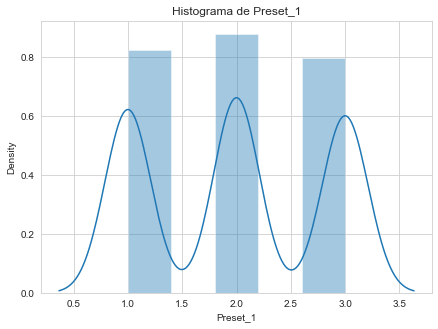

In [13]:
fig, ax=plt.subplots(figsize=(7,5))
ax.set_title('Histograma de Preset_1')
sns.distplot(df['Preset_1'], ax=ax)

### Box-Plot

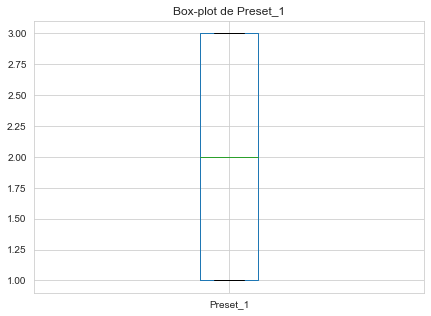

In [13]:
plt.figure(figsize=(7,5))
plt.title('Box-plot de Preset_1')
df.boxplot(column=['Preset_1'])

### Cycle x Preset_2

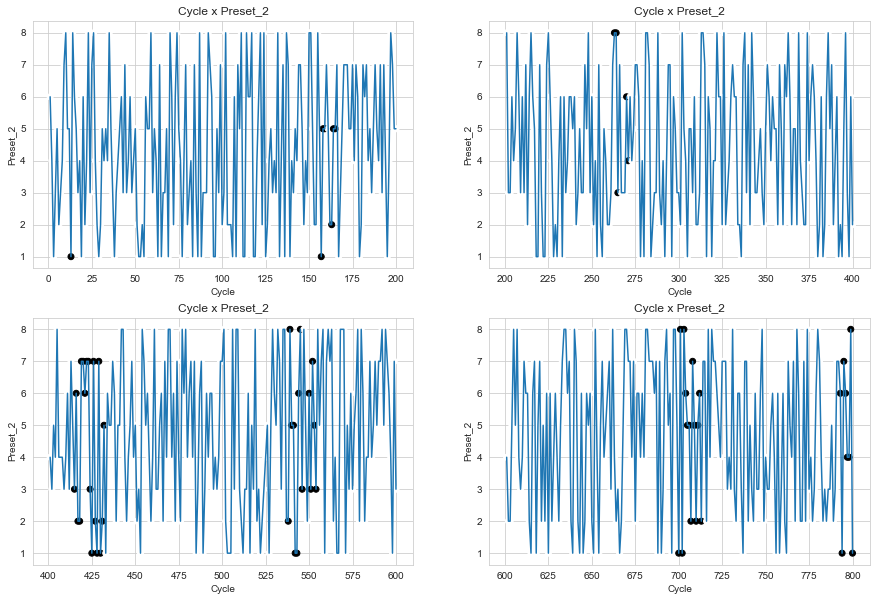

In [14]:
#plt.figure(figsize = (20,15))
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0, 0].set_title('Cycle x Preset_2')
ax[0, 0].set_xlabel('Cycle')
ax[0, 0].set_ylabel('Preset_2')
ax[0, 0].scatter(df['Cycle'][:n1],df['Preset_2'][:n1],c=color_fail[:n1])
ax[0, 0].plot(df['Cycle'][:n1],df['Preset_2'][:n1])

ax[0, 1].set_title('Cycle x Preset_2')
ax[0, 1].set_xlabel('Cycle')
ax[0, 1].set_ylabel('Preset_2')
ax[0, 1].scatter(df['Cycle'][n1:n2],df['Preset_2'][n1:n2],c=color_fail[n1:n2])
ax[0, 1].plot(df['Cycle'][n1:n2],df['Preset_2'][n1:n2])

ax[1, 0].set_title('Cycle x Preset_2')
ax[1, 0].set_xlabel('Cycle')
ax[1, 0].set_ylabel('Preset_2')
ax[1, 0].scatter(df['Cycle'][n2:n3],df['Preset_2'][n2:n3],c=color_fail[n2:n3])
ax[1, 0].plot(df['Cycle'][n2:n3],df['Preset_2'][n2:n3])

ax[1, 1].set_title('Cycle x Preset_2')
ax[1, 1].set_xlabel('Cycle')
ax[1, 1].set_ylabel('Preset_2')
ax[1, 1].scatter(df['Cycle'][n3:n4],df['Preset_2'][n3:n4],c=color_fail[n3:n4])
ax[1, 1].plot(df['Cycle'][n3:n4],df['Preset_2'][n3:n4])

plt.show()


### Histograma

C:\Users\Public\Anaconda3\envs\ITALO\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Histograma de Preset_2'}, xlabel='Preset_2', ylabel='Density'>

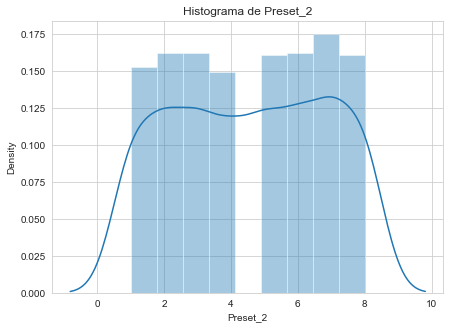

In [14]:
fig, ax=plt.subplots(figsize=(7,5))
ax.set_title('Histograma de Preset_2')
sns.distplot(df['Preset_2'], ax=ax)

### Box-Plot

<AxesSubplot:title={'center':'Box-plot de Preset_2'}>

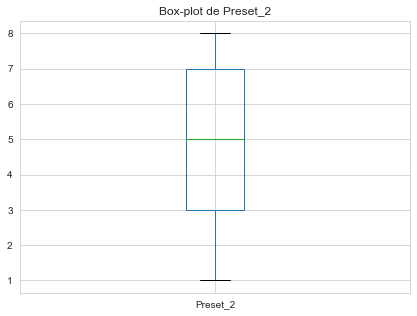

In [15]:
plt.figure(figsize=(7,5))
plt.title('Box-plot de Preset_2')
df.boxplot(column=['Preset_2'])

### Cycle x Temperature

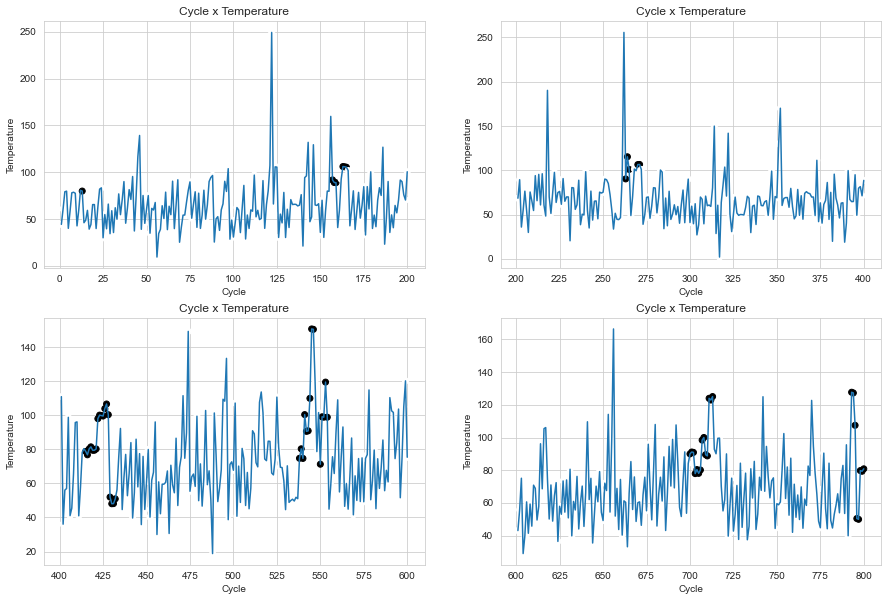

In [16]:
#plt.figure(figsize = (20,15))
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0, 0].set_title('Cycle x Temperature')
ax[0, 0].set_xlabel('Cycle')
ax[0, 0].set_ylabel('Temperature')
ax[0, 0].scatter(df['Cycle'][:n1],df['Temperature'][:n1],c=color_fail[:n1])
ax[0, 0].plot(df['Cycle'][:n1],df['Temperature'][:n1])

ax[0, 1].set_title('Cycle x Temperature')
ax[0, 1].set_xlabel('Cycle')
ax[0, 1].set_ylabel('Temperature')
ax[0, 1].scatter(df['Cycle'][n1:n2],df['Temperature'][n1:n2],c=color_fail[n1:n2])
ax[0, 1].plot(df['Cycle'][n1:n2],df['Temperature'][n1:n2])

ax[1, 0].set_title('Cycle x Temperature')
ax[1, 0].set_xlabel('Cycle')
ax[1, 0].set_ylabel('Temperature')
ax[1, 0].scatter(df['Cycle'][n2:n3],df['Temperature'][n2:n3],c=color_fail[n2:n3])
ax[1, 0].plot(df['Cycle'][n2:n3],df['Temperature'][n2:n3])

ax[1, 1].set_title('Cycle x Temperature')
ax[1, 1].set_xlabel('Cycle')
ax[1, 1].set_ylabel('Temperature')
ax[1, 1].scatter(df['Cycle'][n3:n4],df['Temperature'][n3:n4],c=color_fail[n3:n4])
ax[1, 1].plot(df['Cycle'][n3:n4],df['Temperature'][n3:n4])

plt.show()


### Histograma

C:\Users\Public\Anaconda3\envs\ITALO\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Histograma de Temperature'}, xlabel='Temperature', ylabel='Density'>

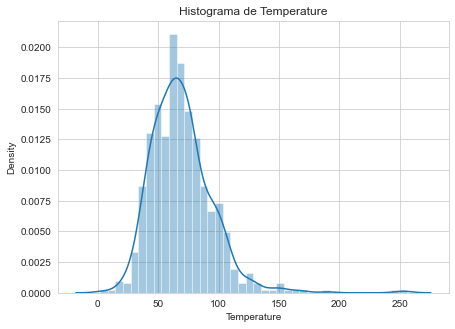

In [17]:
fig, ax=plt.subplots(figsize=(7,5))
ax.set_title('Histograma de Temperature')
sns.distplot(df['Temperature'], ax=ax)

### Box-Plot

<AxesSubplot:title={'center':'Box-plot de Temperature'}>

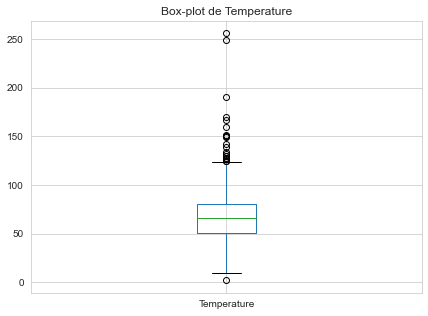

In [18]:
plt.figure(figsize=(7,5))
plt.title('Box-plot de Temperature')
df.boxplot(column=['Temperature'])

### Cycle x Pressure

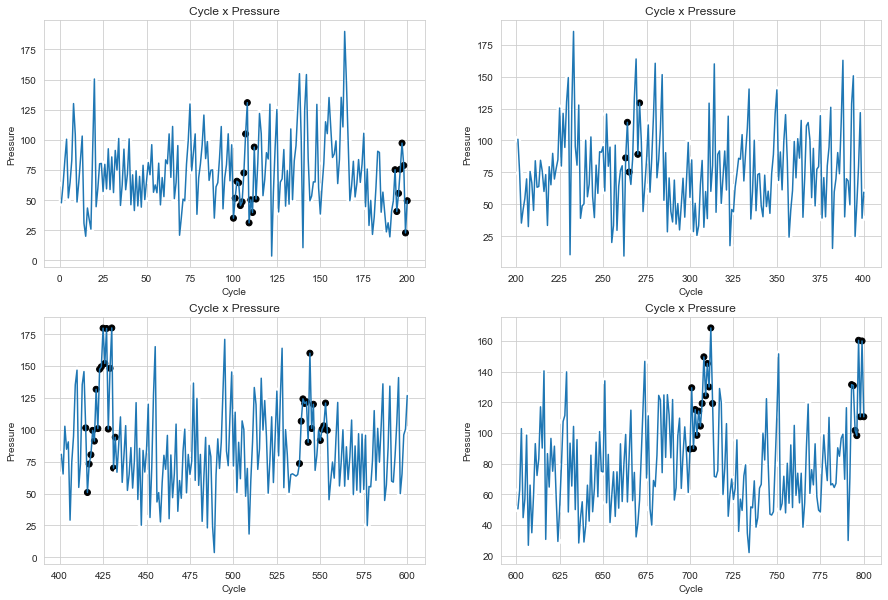

In [19]:
#plt.figure(figsize = (20,15))
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0, 0].set_title('Cycle x Pressure')
ax[0, 0].set_xlabel('Cycle')
ax[0, 0].set_ylabel('Pressure')
ax[0, 0].scatter(df['Cycle'][:n1],df['Pressure'][:n1],c=color_fail[n3:n4])
ax[0, 0].plot(df['Cycle'][:n1],df['Pressure'][:n1])

ax[0, 1].set_title('Cycle x Pressure')
ax[0, 1].set_xlabel('Cycle')
ax[0, 1].set_ylabel('Pressure')
ax[0, 1].scatter(df['Cycle'][n1:n2],df['Pressure'][n1:n2],c=color_fail[n1:n2])
ax[0, 1].plot(df['Cycle'][n1:n2],df['Pressure'][n1:n2])

ax[1, 0].set_title('Cycle x Pressure')
ax[1, 0].set_xlabel('Cycle')
ax[1, 0].set_ylabel('Pressure')
ax[1, 0].scatter(df['Cycle'][n2:n3],df['Pressure'][n2:n3],c=color_fail[n2:n3])
ax[1, 0].plot(df['Cycle'][n2:n3],df['Pressure'][n2:n3])

ax[1, 1].set_title('Cycle x Pressure')
ax[1, 1].set_xlabel('Cycle')
ax[1, 1].set_ylabel('Pressure')
ax[1, 1].scatter(df['Cycle'][n3:n4],df['Pressure'][n3:n4],c=color_fail[n3:n4])
ax[1, 1].plot(df['Cycle'][n3:n4],df['Pressure'][n3:n4])

plt.show()


### Histograma

C:\Users\Public\Anaconda3\envs\ITALO\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Histograma de Pressure'}, xlabel='Pressure', ylabel='Density'>

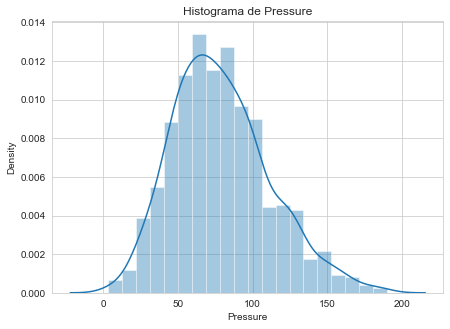

In [20]:
fig, ax=plt.subplots(figsize=(7,5))
ax.set_title('Histograma de Pressure')
sns.distplot(df['Pressure'], ax=ax)

### Box-Plot

<AxesSubplot:title={'center':'Box-plot de Pressure'}>

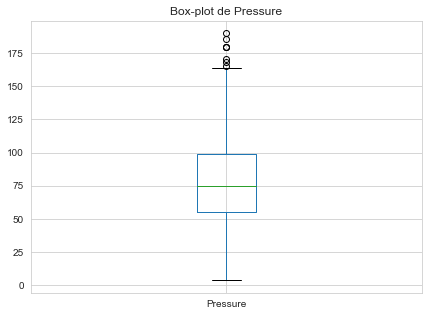

In [21]:
plt.figure(figsize=(7,5))
plt.title('Box-plot de Pressure')
df.boxplot(column=['Pressure'])

### Cycle x VibrationX

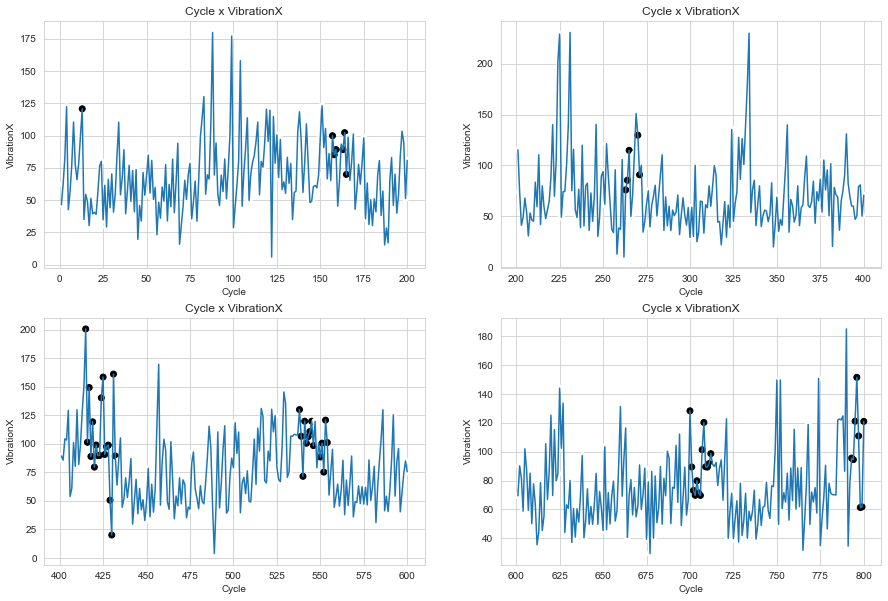

In [22]:
#plt.figure(figsize = (20,15))
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0, 0].set_title('Cycle x VibrationX')
ax[0, 0].set_xlabel('Cycle')
ax[0, 0].set_ylabel('VibrationX')
ax[0, 0].scatter(df['Cycle'][:n1],df['VibrationX'][:n1],c=color_fail[:n1])
ax[0, 0].plot(df['Cycle'][:n1],df['VibrationX'][:n1])

ax[0, 1].set_title('Cycle x VibrationX')
ax[0, 1].set_xlabel('Cycle')
ax[0, 1].set_ylabel('VibrationX')
ax[0, 1].scatter(df['Cycle'][n1:n2],df['VibrationX'][n1:n2],c=color_fail[n1:n2])
ax[0, 1].plot(df['Cycle'][n1:n2],df['VibrationX'][n1:n2])

ax[1, 0].set_title('Cycle x VibrationX')
ax[1, 0].set_xlabel('Cycle')
ax[1, 0].set_ylabel('VibrationX')
ax[1, 0].scatter(df['Cycle'][n2:n3],df['VibrationX'][n2:n3],c=color_fail[n2:n3])
ax[1, 0].plot(df['Cycle'][n2:n3],df['VibrationX'][n2:n3])

ax[1, 1].set_title('Cycle x VibrationX')
ax[1, 1].set_xlabel('Cycle')
ax[1, 1].set_ylabel('VibrationX')
ax[1, 1].scatter(df['Cycle'][n3:n4],df['VibrationX'][n3:n4],c=color_fail[n3:n4])
ax[1, 1].plot(df['Cycle'][n3:n4],df['VibrationX'][n3:n4])

plt.show()


### Histograma

C:\Users\Public\Anaconda3\envs\ITALO\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Histograma de VibrationX'}, xlabel='VibrationX', ylabel='Density'>

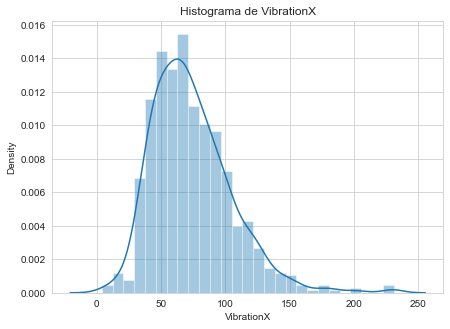

In [23]:
fig, ax=plt.subplots(figsize=(7,5))
ax.set_title('Histograma de VibrationX')
sns.distplot(df['VibrationX'], ax=ax)

### Box-Plot

<AxesSubplot:title={'center':'Box-plot de VibrationX'}>

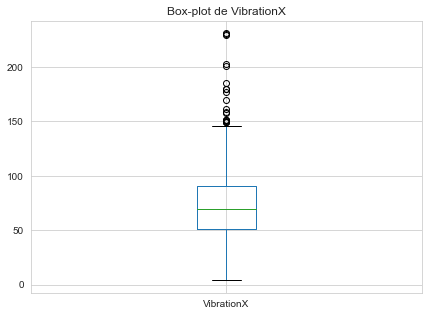

In [24]:
plt.figure(figsize=(7,5))
plt.title('Box-plot de VibrationX')
df.boxplot(column=['VibrationX'])

### Cycle x VibrationY

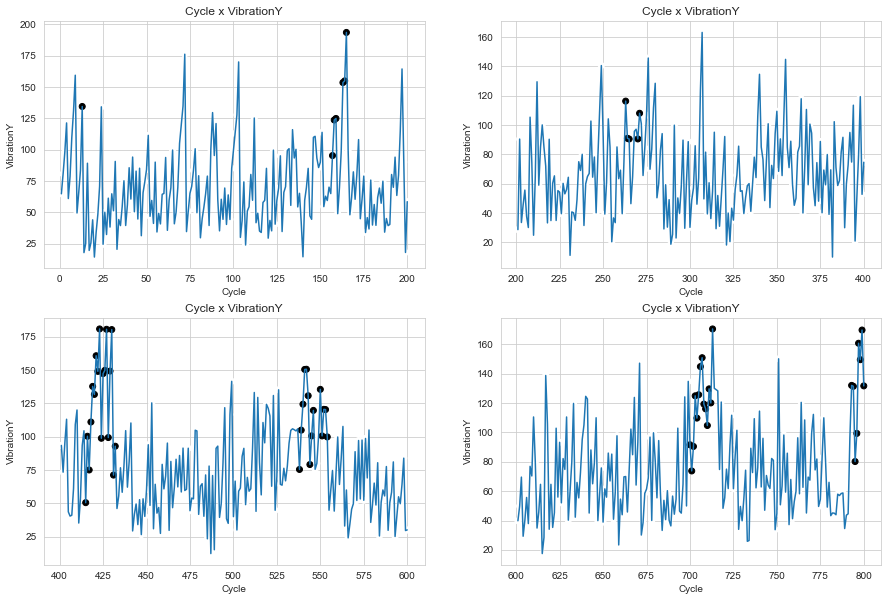

In [25]:
#plt.figure(figsize = (20,15))
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0, 0].set_title('Cycle x VibrationY')
ax[0, 0].set_xlabel('Cycle')
ax[0, 0].set_ylabel('VibrationY')
ax[0, 0].scatter(df['Cycle'][:n1],df['VibrationY'][:n1],c=color_fail[:n1])
ax[0, 0].plot(df['Cycle'][:n1],df['VibrationY'][:n1])

ax[0, 1].set_title('Cycle x VibrationY')
ax[0, 1].set_xlabel('Cycle')
ax[0, 1].set_ylabel('VibrationY')
ax[0, 1].scatter(df['Cycle'][n1:n2],df['VibrationY'][n1:n2],c=color_fail[n1:n2])
ax[0, 1].plot(df['Cycle'][n1:n2],df['VibrationY'][n1:n2])

ax[1, 0].set_title('Cycle x VibrationY')
ax[1, 0].set_xlabel('Cycle')
ax[1, 0].set_ylabel('VibrationY')
ax[1, 0].scatter(df['Cycle'][n2:n3],df['VibrationY'][n2:n3],c=color_fail[n2:n3])
ax[1, 0].plot(df['Cycle'][n2:n3],df['VibrationY'][n2:n3])

ax[1, 1].set_title('Cycle x VibrationY')
ax[1, 1].set_xlabel('Cycle')
ax[1, 1].set_ylabel('VibrationY')
ax[1, 1].scatter(df['Cycle'][n3:n4],df['VibrationY'][n3:n4],c=color_fail[n3:n4])
ax[1, 1].plot(df['Cycle'][n3:n4],df['VibrationY'][n3:n4])

plt.show()


### Histograma

C:\Users\Public\Anaconda3\envs\ITALO\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Histograma de VibrationY'}, xlabel='VibrationY', ylabel='Density'>

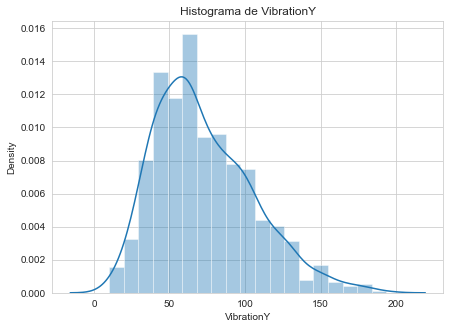

In [26]:
fig, ax=plt.subplots(figsize=(7,5))
ax.set_title('Histograma de VibrationY')
sns.distplot(df['VibrationY'], ax=ax)

### Box-Plot

<AxesSubplot:title={'center':'Box-plot de VibrationY'}>

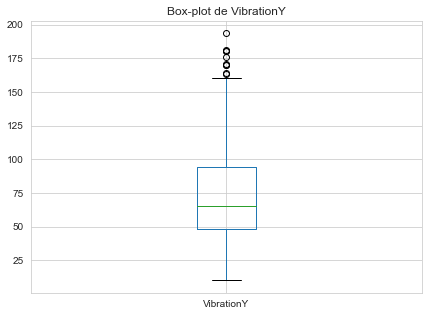

In [27]:
plt.figure(figsize=(7,5))
plt.title('Box-plot de VibrationY')
df.boxplot(column=['VibrationY'])

### Cycle x VibrationZ

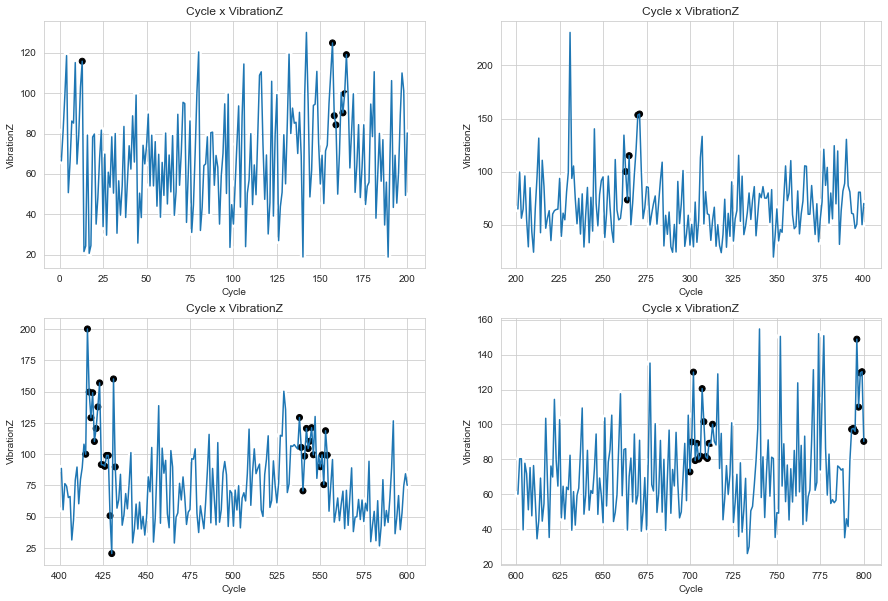

In [28]:
#plt.figure(figsize = (20,15))
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0, 0].set_title('Cycle x VibrationZ')
ax[0, 0].set_xlabel('Cycle')
ax[0, 0].set_ylabel('VibrationZ')
ax[0, 0].scatter(df['Cycle'][:n1],df['VibrationZ'][:n1],c=color_fail[:n1])
ax[0, 0].plot(df['Cycle'][:n1],df['VibrationZ'][:n1])

ax[0, 1].set_title('Cycle x VibrationZ')
ax[0, 1].set_xlabel('Cycle')
ax[0, 1].set_ylabel('VibrationZ')
ax[0, 1].scatter(df['Cycle'][n1:n2],df['VibrationZ'][n1:n2],c=color_fail[n1:n2])
ax[0, 1].plot(df['Cycle'][n1:n2],df['VibrationZ'][n1:n2])

ax[1, 0].set_title('Cycle x VibrationZ')
ax[1, 0].set_xlabel('Cycle')
ax[1, 0].set_ylabel('VibrationZ')
ax[1, 0].scatter(df['Cycle'][n2:n3],df['VibrationZ'][n2:n3],c=color_fail[n2:n3])
ax[1, 0].plot(df['Cycle'][n2:n3],df['VibrationZ'][n2:n3])

ax[1, 1].set_title('Cycle x VibrationZ')
ax[1, 1].set_xlabel('Cycle')
ax[1, 1].set_ylabel('VibrationZ')
ax[1, 1].scatter(df['Cycle'][n3:n4],df['VibrationZ'][n3:n4],c=color_fail[n3:n4])
ax[1, 1].plot(df['Cycle'][n3:n4],df['VibrationZ'][n3:n4])

plt.show()


### Histograma

C:\Users\Public\Anaconda3\envs\ITALO\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Histograma de VibrationZ'}, xlabel='VibrationZ', ylabel='Density'>

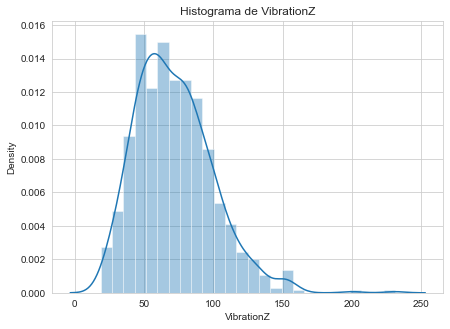

In [29]:
fig, ax=plt.subplots(figsize=(7,5))
ax.set_title('Histograma de VibrationZ')
sns.distplot(df['VibrationZ'], ax=ax)

### Box-Plot

<AxesSubplot:title={'center':'Box-plot de VibrationZ'}>

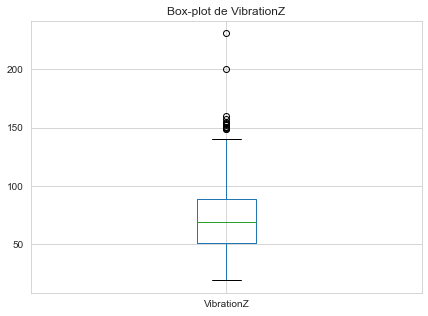

In [30]:
plt.figure(figsize=(7,5))
plt.title('Box-plot de VibrationZ')
df.boxplot(column=['VibrationZ'])

### Cycle x Frequency

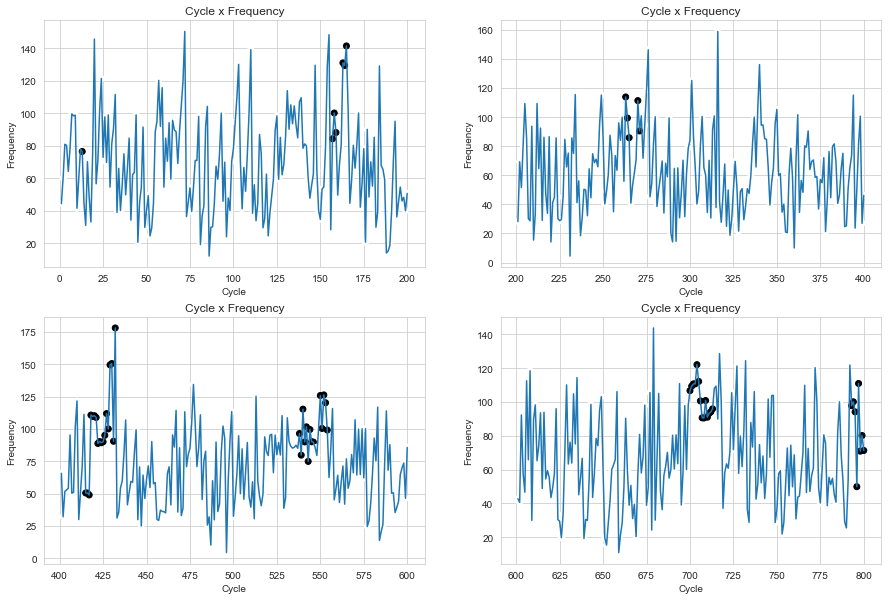

In [31]:
#plt.figure(figsize = (20,15))
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0, 0].set_title('Cycle x Frequency')
ax[0, 0].set_xlabel('Cycle')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].scatter(df['Cycle'][:n1],df['Frequency'][:n1],c=color_fail[:n1])
ax[0, 0].plot(df['Cycle'][:n1],df['Frequency'][:n1])

ax[0, 1].set_title('Cycle x Frequency')
ax[0, 1].set_xlabel('Cycle')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].scatter(df['Cycle'][n1:n2],df['Frequency'][n1:n2],c=color_fail[n1:n2])
ax[0, 1].plot(df['Cycle'][n1:n2],df['Frequency'][n1:n2])

ax[1, 0].set_title('Cycle x Frequency')
ax[1, 0].set_xlabel('Cycle')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].scatter(df['Cycle'][n2:n3],df['Frequency'][n2:n3],c=color_fail[n2:n3])
ax[1, 0].plot(df['Cycle'][n2:n3],df['Frequency'][n2:n3])

ax[1, 1].set_title('Cycle x Frequency')
ax[1, 1].set_xlabel('Cycle')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].scatter(df['Cycle'][n3:n4],df['Frequency'][n3:n4],c=color_fail[n3:n4])
ax[1, 1].plot(df['Cycle'][n3:n4],df['Frequency'][n3:n4])

plt.show()


### Histograma

C:\Users\Public\Anaconda3\envs\ITALO\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Histograma de Frequency'}, xlabel='Frequency', ylabel='Density'>

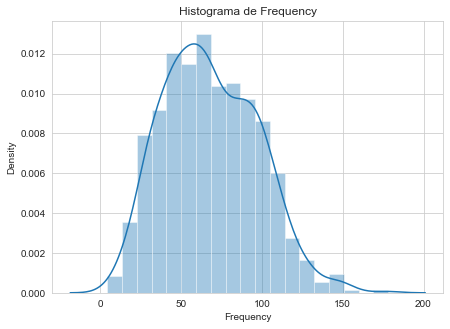

In [32]:
fig, ax=plt.subplots(figsize=(7,5))
ax.set_title('Histograma de Frequency')
sns.distplot(df['Frequency'], ax=ax)

### Box-Plot

<AxesSubplot:title={'center':'Box-plot de Frequency'}>

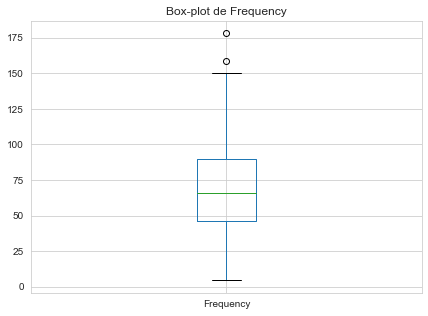

In [35]:
plt.figure(figsize=(7,5))
plt.title('Box-plot de Frequency')
df.boxplot(column=['Frequency'])

### Cycle x Fail

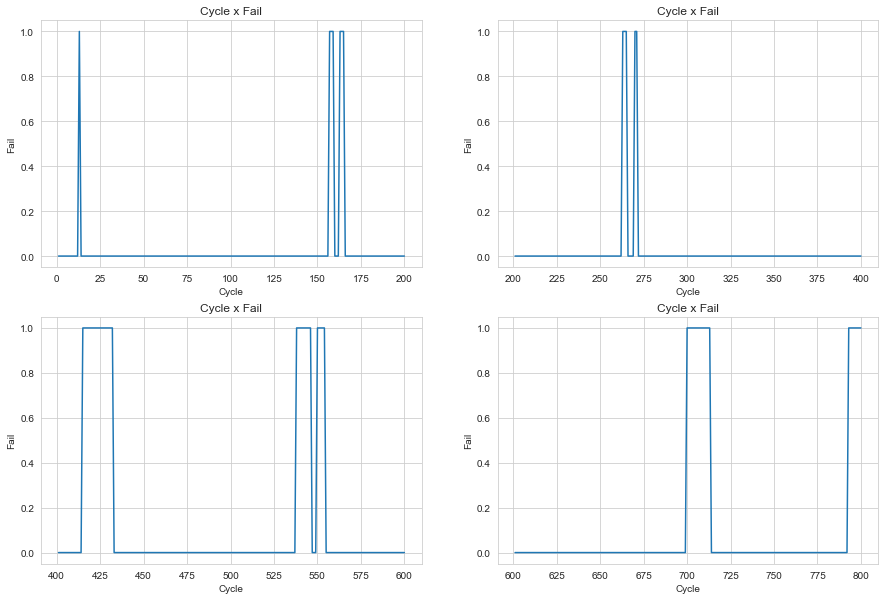

In [36]:
#plt.figure(figsize = (20,15))
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0, 0].set_title('Cycle x Fail')
ax[0, 0].set_xlabel('Cycle')
ax[0, 0].set_ylabel('Fail')
ax[0, 0].plot(df['Cycle'][:n1],df['Fail'][:n1])

ax[0, 1].set_title('Cycle x Fail')
ax[0, 1].set_xlabel('Cycle')
ax[0, 1].set_ylabel('Fail')
ax[0, 1].plot(df['Cycle'][n1:n2],df['Fail'][n1:n2])

ax[1, 0].set_title('Cycle x Fail')
ax[1, 0].set_xlabel('Cycle')
ax[1, 0].set_ylabel('Fail')
ax[1, 0].plot(df['Cycle'][n2:n3],df['Fail'][n2:n3])

ax[1, 1].set_title('Cycle x Fail')
ax[1, 1].set_xlabel('Cycle')
ax[1, 1].set_ylabel('Fail')
ax[1, 1].plot(df['Cycle'][n3:n4],df['Fail'][n3:n4])

plt.show()


### Analisando os gráficos de dispersão vemos que grande parte das variáveis se assemelha a uma distribuição normal, e através dos box-plots vemos que muitas delas contém outliers

### Seleção de Atributos

In [372]:
# TODO: Faça uma cópia do DataFrame, usando a função 'drop' para descartar o recurso fornecido
var= 'Preset_2'
new_data = df.drop(var, axis = 1, inplace = False)

# TODO: Divida os dados em conjuntos de treinamento e teste (0,25) usando o recurso determinado como o destino
# Definir um estado aleatório.
X_train, X_test, y_train, y_test = train_test_split(df, new_data,test_size=0.25, random_state=42)

# TODO: crie um regressor de árvore de decisão e ajuste-o ao conjunto de treinamento
regressor = DecisionTreeRegressor(random_state=30).fit(X_train,y_train)

# TODO: Relate a pontuação da previsão usando o conjunto de testes
score = regressor.score(X_test,y_test)

print('O score com o recurso ',var,' removido foi de ',score)

O score com o recurso  Preset_2  removido foi de  0.9241130738555015


C:\Users\Public\Anaconda3\envs\ITALO\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


#### Se conseguirmos remover uma variável do conjunto de dados e mesmo assim conseguir preve-la com boa precisão, à partir das outras, isso significa que essa variável não é muito relevante para nosso problema, como é o caso da variável 'Preset_2'

In [8]:
df['Fail']=df['Fail'].astype('int64',inplace=True)
df.head()
# convertendo a variável categórica target para visualizar na matriz de dispersão

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,0
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,0
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,0
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,0
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,0


### Visualizando as distribuições dos recursos

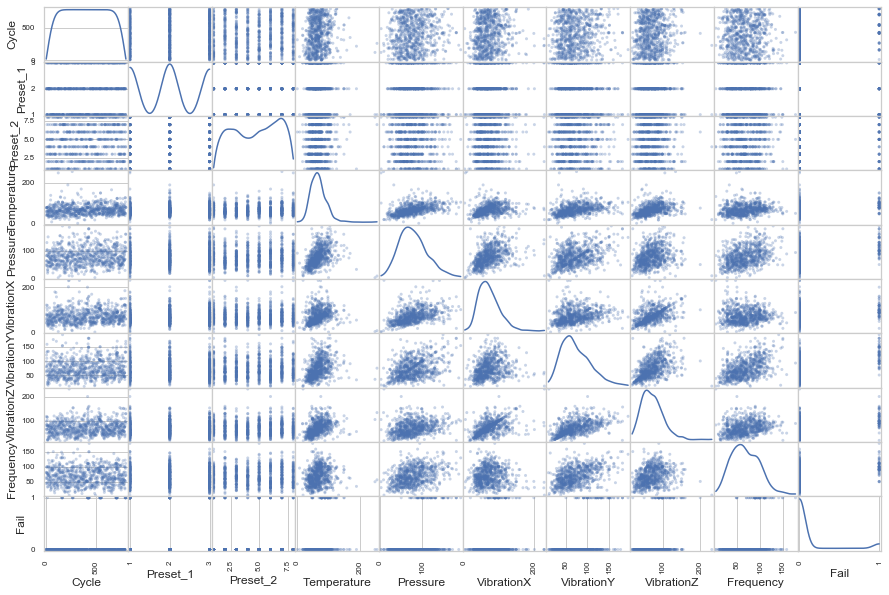

In [374]:
pd.plotting.scatter_matrix(df, alpha = 0.3, figsize = (15,10), diagonal = 'kde');

### A matriz de dispersão mostra o coeficiente de correlação de person entre os recursos

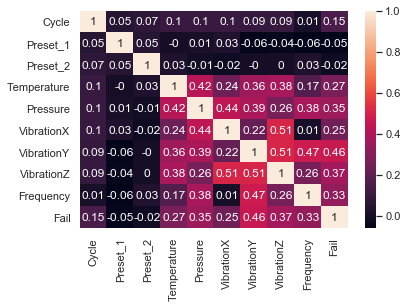

In [375]:
import seaborn as sns; sns.set()

sns.heatmap(df.corr().round(2),annot=True)

### O mapa de calor mostra que o recurso Preset_2 possui uma baixa correlação com a variável alvo Fail, portanto é pouco relevante para prevê-la, confirmando a nossa suspeita anterior, também possui baixa correlação com as outras variáveis preditoras, portanto vamos removê-la do conjunto de dados

### OBS: Uma alta corelação positiva entre a variável alvo e a variável preditora é altamente desejável pois significa que essa variável é importante para a previsão, alta corelação positiva entre as variáveis independentes é indesejável pois assim estamos fornecendo informações redundantes ao modelo.

In [9]:
delete_vars= ['Preset_2']
new_df = df.drop(delete_vars, axis = 1, inplace = False)

### Excluindo variáveis indesejáveis do conjunto de dados

## Pré-processamento dos Dados

In [10]:
numerical = ['Cycle', 'Preset_1','Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']

scaler = MinMaxScaler(feature_range=(-1,1))

new_df[numerical] = scaler.fit_transform(new_df[numerical])

In [11]:
new_df.head()

,Cycle,Preset_1,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,-1.000000,1.0,-0.667513,-0.526291,-0.624734,-0.403172,-0.550634,-0.538275,0
1,-0.997497,0.0,-0.536776,-0.359926,-0.487614,-0.229951,-0.411197,-0.356991,0
2,-0.994994,0.0,-0.393037,-0.146967,-0.305809,-0.038793,-0.245867,-0.117917,0
3,-0.992491,0.0,-0.387604,0.040433,0.044126,0.213060,-0.058587,-0.125722,0
4,-0.989987,0.0,-0.701010,-0.482246,-0.659335,-0.444395,-0.698989,-0.310748,0


### Usando a codificação MinMaxScaler para transformar e redimensionar as variáveis numéricas para o intervalo -1 até 1, e amenizar os efeitos dos outliers, para que os dados tenham uma distribuição mais próxima da normal

## Tratamento de outliers

In [60]:
df_scaled=new_df.copy()
outliers=[]
#Para cada recurso, encontre os pontos de dados com valores extremos altos ou baixos
for feature in df_scaled.keys():
    #TODO: Calcular Q1 (25º percentil dos dados) para o recurso fornecido
    Q1 = np.percentile(df_scaled[feature],25)
    #TODO: Calcular Q3 (75º percentil dos dados) para o recurso fornecido
    Q3 = np.percentile(df_scaled[feature],75)
    #TODO: use o intervalo interquartil para calcular um passo de discrepância (1,5 vezes o intervalo interquartil)
    step = 1.5*(Q3 - Q1)
    #Exibir os outliers
    print("Pontos de dados considerados outliers para o recurso '{}':".format(feature))
    delete=df_scaled[~((df_scaled[feature] >= Q1 - step) & (df_scaled[feature] <= Q3 + step))]
    print(delete)
    outliers+=list(delete.index)
    
good_data = df_scaled.drop(df_scaled.index[outliers]).reset_index(drop = True)

Pontos de dados considerados outliers para o recurso 'Cycle':
Empty DataFrame
Columns: [Cycle, Preset_1, Temperature, Pressure, VibrationX, VibrationY, VibrationZ, Frequency, Fail]
Index: []
Pontos de dados considerados outliers para o recurso 'Preset_1':
Empty DataFrame
Columns: [Cycle, Preset_1, Temperature, Pressure, VibrationX, VibrationY, VibrationZ, Frequency, Fail]
Index: []
Pontos de dados considerados outliers para o recurso 'Temperature':
        Cycle  Preset_1  Temperature  Pressure  VibrationX  VibrationY  \
45  -0.887359       1.0     0.081437 -0.290443   -0.630298   -0.180721   
121 -0.697121      -1.0     0.949509 -1.000000   -0.982253   -0.725487   
142 -0.644556       1.0     0.023545 -0.129821   -0.334927   -0.182101   
145 -0.637046      -1.0     0.003391 -0.339575   -0.501046    0.087591   
155 -0.612015       0.0     0.242182  0.145122   -0.459935   -0.401359   
185 -0.536921       1.0    -0.017272 -0.430497   -0.531388   -0.293684   
217 -0.456821       0.0     0

In [381]:
good_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 10 columns):
Cycle          691 non-null float64
Preset_1       691 non-null float64
Temperature    691 non-null float64
Pressure       691 non-null float64
VibrationX     691 non-null float64
VibrationY     691 non-null float64
VibrationZ     691 non-null float64
Frequency      691 non-null float64
Fail_0         691 non-null uint8
Fail_1         691 non-null uint8
dtypes: float64(8), uint8(2)
memory usage: 44.6 KB


### OBS embora existam muitos outliers, não podemos removê-los, pois basicamente esse em um problema de manutenção preditiva, então estamos interessados em detectar justamente os outliers

## Embaralhando e dividindo os dados em conjunto de treinamento 80% e testes 20%, preservando nos conjuntos de treinamento e testes a mesma proporção da variável alvo do dataset original.

In [33]:
# PULAR ESSA PARTE!!
"""

X_train, X_test, y_train, y_test = train_test_split(df_scaled[numerical], 
                                                    df_scaled[['Fail_0', 'Fail_1']], 
                                                    test_size = 0.2, 
                                                    stratify=df_scaled['Fail_0'],
                                                    random_state = 0)

print("Conjunto de Treinamento tem {} amostras.".format(X_train.shape[0]))
print("Conjunto de Testes tem {} amostras.".format(X_test.shape[0]))
"""

'\n\nX_train, X_test, y_train, y_test = train_test_split(df_scaled[numerical], \n                                                    df_scaled[[\'Fail_0\', \'Fail_1\']], \n                                                    test_size = 0.2, \n                                                    stratify=df_scaled[\'Fail_0\'],\n                                                    random_state = 0)\n\nprint("Conjunto de Treinamento tem {} amostras.".format(X_train.shape[0]))\nprint("Conjunto de Testes tem {} amostras.".format(X_test.shape[0]))\n'

### Salvando os dados de treinamento e testes para reproduzi-los posteriormente

In [318]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')

In [319]:
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

### Carregando os dados de treinamento e testes

In [2]:
X_train=pd.read_csv('X_train.csv').drop('Unnamed: 0',axis=1)
X_test=pd.read_csv('X_test.csv').drop('Unnamed: 0',axis=1)

In [3]:
y_train=pd.read_csv('y_train.csv').drop('Unnamed: 0',axis=1)
y_test=pd.read_csv('y_test.csv').drop('Unnamed: 0',axis=1)

In [4]:
print("Conjunto de Treinamento tem {} amostras.".format(X_train.shape[0]))
print("Conjunto de Testes tem {} amostras.".format(X_test.shape[0]))

Conjunto de Treinamento tem 640 amostras.
Conjunto de Testes tem 160 amostras.


### Analizando a proporção da classe alvo nos conjuntos de treinamento e testes

In [15]:
y_train['Fail'].value_counts()

1    583
0     57
Name: Fail, dtype: int64

In [16]:
y_train['Fail'].value_counts()/len(y_train)

1    0.910937
0    0.089063
Name: Fail, dtype: float64

### Aproximadamente 8% de casos de falha no conjunto de treinamento

In [5]:
y_test['Fail'].value_counts()

1    151
0      9
Name: Fail, dtype: int64

In [6]:
y_test['Fail'].value_counts()/len(y_test)

1    0.94375
0    0.05625
Name: Fail, dtype: float64

### Aproximadamente 5% de casos de falha no conjunto de testes

### Os casos de falha estão bem distribuídos no conjunto de treinamento e testes, os dados estão bem divididos, obs: 0 representa os casos em que ocorre falhas

## Modelagem
### Manutenção Preditiva

In [19]:
model_1 = DecisionTreeClassifier(random_state=44)
model_1.fit(X_train,y_train.values)
predictions_1=model_1.predict(X_test)

beta=10 # favorece mais o recall
accuracy_1=accuracy_score(y_test.values, predictions_1)
fB_score_1=fbeta_score(y_test.values, predictions_1,beta,average='micro') #[None, 'micro', 'macro', 'weighted', 'samples']
recall_score_1=recall_score(y_test.values, predictions_1, average='micro')
precision_score_1=precision_score(y_test.values, predictions_1, average='micro')
tn_1, fp_1, fn_1, tp_1=confusion_matrix(y_test.values, predictions_1).ravel()

In [20]:
print('Acurácia para o conjunto de testes para a árvore de decisão não otimizada: {:.3f}  %'.format(accuracy_1*100))
print('F5 Score para o conjunto de testes para a árvore de decisão não otimizada: {:.3f}  %'.format(fB_score_1*100))
print('Recall(sensibilidade) para o conjunto de testes para a árvore de decisão não otimizada: {:.3f}  %'.format(recall_score_1*100))
print('Precisão para o conjunto de testes para a árvore de decisão não otimizada: {:.3f}  %'.format(precision_score_1*100))
print('Verdadeiros negativos para o conjunto de testes para a árvore de decisão não otimizada: {0}'.format(tn_1))
print('Falsos positivos para o conjunto de testes para a árvore de decisão não otimizada: {0}'.format(fp_1))
print('Falsos negativos para o conjunto de testes para a árvore de decisão não otimizada: {0}'.format(fn_1))
print('Verdadeiros positivos para o conjunto de testes para a árvore de decisão não otimizada: {0}'.format(tp_1))

Acurácia para o conjunto de testes para a árvore de decisão não otimizada: 95.000  %
F5 Score para o conjunto de testes para a árvore de decisão não otimizada: 95.000  %
Recall(sensibilidade) para o conjunto de testes para a árvore de decisão não otimizada: 95.000  %
Precisão para o conjunto de testes para a árvore de decisão não otimizada: 95.000  %
Verdadeiros negativos para o conjunto de testes para a árvore de decisão não otimizada: 6
Falsos positivos para o conjunto de testes para a árvore de decisão não otimizada: 3
Falsos negativos para o conjunto de testes para a árvore de decisão não otimizada: 5
Verdadeiros positivos para o conjunto de testes para a árvore de decisão não otimizada: 146


C:\Users\Matheus Guimarães\Documents\Italo\MODEC-PROCESSO-ITALO-ATUALIZADO\confusion_matrix_pretty_print.py:165: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
C:\Users\Matheus Guimarães\Documents\Italo\MODEC-PROCESSO-ITALO-ATUALIZADO\confusion_matrix_pretty_print.py:166: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
C:\Users\Matheus Guimarães\Documents\Italo\MODEC-PROCESSO-ITALO-ATUALIZADO\confusion_matrix_pretty_print.py:168: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
C:\Users\Matheus Guimarães\Documents\Italo\MODEC-PROCESSO-ITALO-ATUALIZADO\confusion_matrix_pretty_print.py:169: MatplotlibDeprecationWarning:

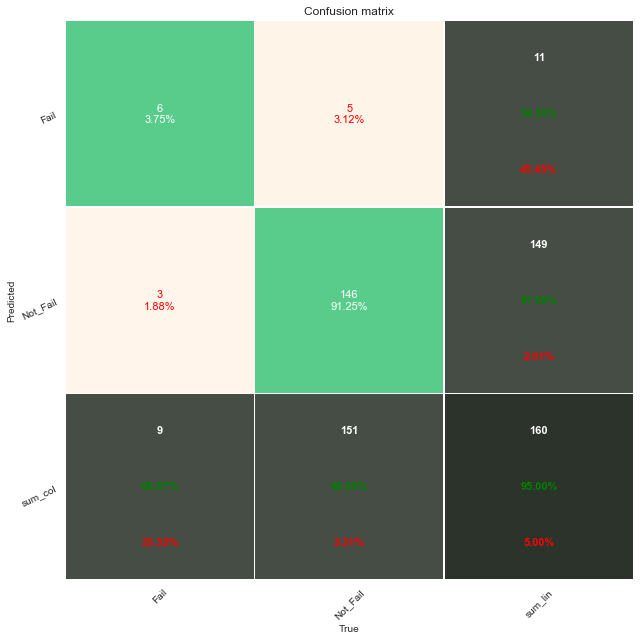

In [21]:
plot_confusion_matrix_from_data(y_test.values, predictions_1, columns=['Fail','Not_Fail'], annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[2,2], show_null_values=0, pred_val_axis='lin')

### O Primeiro modelo escolhido foram as árvore de decisão, pois possuem ótimo desempenho para datasets desbalanceados e dados tabulares como é o caso

In [22]:
model_2 = SVC(kernel='rbf',random_state=44)
model_2.fit(X_train,y_train.values)
predictions_2=model_2.predict(X_test)

beta=5 # favorece mais o recall
accuracy_2=accuracy_score(y_test.values, predictions_2)
fB_score_2=fbeta_score(y_test.values, predictions_2,beta,average='micro') #[None, 'micro', 'macro', 'weighted', 'samples']
recall_score_2=recall_score(y_test.values, predictions_2, average='micro')
precision_score_2=precision_score(y_test.values, predictions_2, average='micro')
tn_2, fp_2, fn_2, tp_2=confusion_matrix(y_test.values, predictions_2).ravel()

C:\Users\Public\Anaconda3\envs\ITALO\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Public\Anaconda3\envs\ITALO\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [23]:
print('Acurácia para o conjunto de testes para a suport vector machine não otimizada: {:.3f}  %'.format(accuracy_2*100))
print('F5 Score para o conjunto de testes para a suport vector machine não otimizada: {:.3f}  %'.format(fB_score_2*100))
print('Recall(sensibilidade) para o conjunto de testes para a suport vector machine não otimizada: {:.3f}  %'.format(recall_score_2*100))
print('Precisão para o conjunto de testes para a suport vector machine não otimizada: {:.3f}  %'.format(precision_score_2*100))
print('Verdadeiros negativos para o conjunto de testes para a suport vector machine não otimizada: {0}'.format(tn_2))
print('Falsos positivos para o conjunto de testes para a suport vector machine não otimizada: {0}'.format(fp_2))
print('Falsos negativos para o conjunto de testes para a suport vector machine não otimizada: {0}'.format(fn_2))
print('Verdadeiros positivos para o conjunto de testes para a suport vector machine não otimizada: {0}'.format(tp_2))

Acurácia para o conjunto de testes para a suport vector machine não otimizada: 95.000  %
F5 Score para o conjunto de testes para a suport vector machine não otimizada: 95.000  %
Recall(sensibilidade) para o conjunto de testes para a suport vector machine não otimizada: 95.000  %
Precisão para o conjunto de testes para a suport vector machine não otimizada: 95.000  %
Verdadeiros negativos para o conjunto de testes para a suport vector machine não otimizada: 2
Falsos positivos para o conjunto de testes para a suport vector machine não otimizada: 7
Falsos negativos para o conjunto de testes para a suport vector machine não otimizada: 1
Verdadeiros positivos para o conjunto de testes para a suport vector machine não otimizada: 150


C:\Users\Matheus Guimarães\Documents\Italo\MODEC-PROCESSO-ITALO-ATUALIZADO\confusion_matrix_pretty_print.py:165: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
C:\Users\Matheus Guimarães\Documents\Italo\MODEC-PROCESSO-ITALO-ATUALIZADO\confusion_matrix_pretty_print.py:166: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
C:\Users\Matheus Guimarães\Documents\Italo\MODEC-PROCESSO-ITALO-ATUALIZADO\confusion_matrix_pretty_print.py:168: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
C:\Users\Matheus Guimarães\Documents\Italo\MODEC-PROCESSO-ITALO-ATUALIZADO\confusion_matrix_pretty_print.py:169: MatplotlibDeprecationWarning:

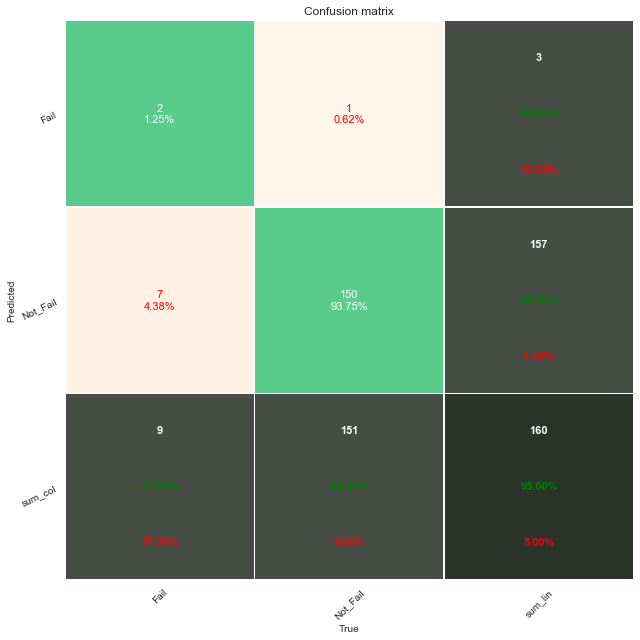

In [24]:
plot_confusion_matrix_from_data(y_test.values, predictions_2, columns=['Fail','Not_Fail'], annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[2,2], show_null_values=0, pred_val_axis='lin')

### O segundo modelo escolhido foi o suport vector machine, algoritimo muito eficiente, e muito utilizado principalmente para detecção de outliers, e de fato, apresentou um desempenho tão bom quanto as árvores de decisão nas métricas de avaliação

In [7]:
model_3 = xgb.XGBClassifier()

model_3.fit(X_train,y_train.values)
predictions_3=model_3.predict(X_test)

beta=5 # favorece mais o recall
accuracy_3=accuracy_score(y_test.values, predictions_3)
fB_score_3=fbeta_score(y_test.values, predictions_3,beta,average='micro') #[None, 'micro', 'macro', 'weighted', 'samples']
recall_score_3=recall_score(y_test.values, predictions_3, average='micro')
precision_score_3=precision_score(y_test.values, predictions_3, average='micro')
tn_3, fp_3, fn_3, tp_3=confusion_matrix(y_test.values, predictions_3).ravel()

C:\Users\Public\Anaconda3\envs\ITALO\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Public\Anaconda3\envs\ITALO\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
print('Acurácia para o conjunto de testes para o XGBoost não otimizado: {:.3f}  %'.format(accuracy_3*100))
print('F5 Score para o conjunto de testes para o XGBoost não otimizado: {:.3f}  %'.format(fB_score_3*100))
print('Recall(sensibilidade) para o conjunto de testes para o XGBoost não otimizado: {:.3f}  %'.format(recall_score_3*100))
print('Precisão para o conjunto de testes para o XGBoost não otimizado: {:.3f}  %'.format(precision_score_3*100))
print('Verdadeiros negativos para o conjunto de testes para o XGBoost não otimizado: {0}'.format(tn_3))
print('Falsos positivos para o conjunto de testes para o XGBoost não otimizado: {0}'.format(fp_3))
print('Falsos negativos para o conjunto de testes para o XGBoost não otimizado: {0}'.format(fn_3))
print('Verdadeiros positivos para o conjunto de testes para o XGBoost não otimizado: {0}'.format(tp_3))

Acurácia para o conjunto de testes para o XGBoost não otimizado: 96.875  %
F5 Score para o conjunto de testes para o XGBoost não otimizado: 96.875  %
Recall(sensibilidade) para o conjunto de testes para o XGBoost não otimizado: 96.875  %
Precisão para o conjunto de testes para o XGBoost não otimizado: 96.875  %
Verdadeiros negativos para o conjunto de testes para o XGBoost não otimizado: 7
Falsos positivos para o conjunto de testes para o XGBoost não otimizado: 2
Falsos negativos para o conjunto de testes para o XGBoost não otimizado: 3
Verdadeiros positivos para o conjunto de testes para o XGBoost não otimizado: 148


C:\Users\Matheus Guimarães\Documents\Italo\MODEC-PROCESSO-ITALO-ATUALIZADO\confusion_matrix_pretty_print.py:165: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
C:\Users\Matheus Guimarães\Documents\Italo\MODEC-PROCESSO-ITALO-ATUALIZADO\confusion_matrix_pretty_print.py:166: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
C:\Users\Matheus Guimarães\Documents\Italo\MODEC-PROCESSO-ITALO-ATUALIZADO\confusion_matrix_pretty_print.py:168: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
C:\Users\Matheus Guimarães\Documents\Italo\MODEC-PROCESSO-ITALO-ATUALIZADO\confusion_matrix_pretty_print.py:169: MatplotlibDeprecationWarning:

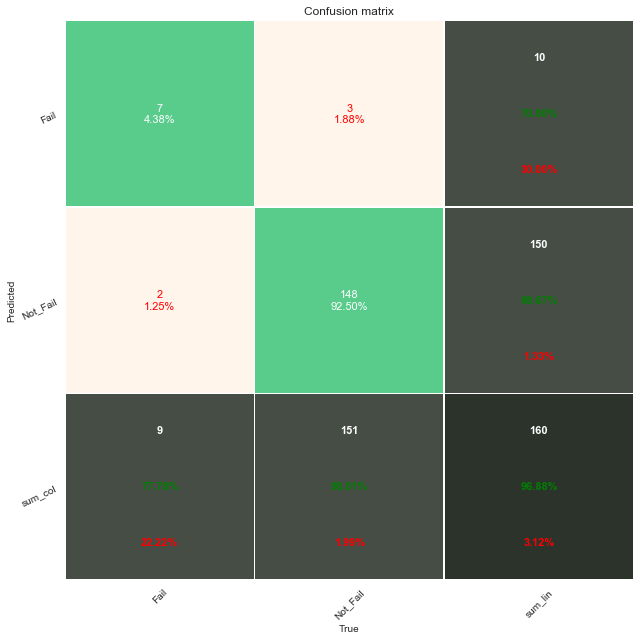

In [9]:
plot_confusion_matrix_from_data(y_test.values, predictions_3, columns=['Fail','Not_Fail'], annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[2,2], show_null_values=0, pred_val_axis='lin')

### O Terceiro modelo escolhido foi o XGBoost, uma evolução das árvores de decisão, grande vencedor da maioria das competições em data science, e como ele foi o modelo que apresentou o melhor desempenho, será escolhido para ser otimizado

## Otimizando o Algoritimo Vencedor

In [396]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }

numFolds = 5
kfold_5 = KFold(shuffle = True, n_splits = numFolds)

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 5, 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)


collector = pd.DataFrame()
estimators = []
results = np.zeros(len(df_scaled[numerical]))
score = 0.0

X=df_scaled[numerical]
y=df_scaled['Fail']

for train_index, test_index in kfold_5.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train,y_train.values)
    estimators.append(clf.best_estimator_)
    preds = clf.best_estimator_.predict(X_test)

    beta=5 # favorece mais o recall
    accuracy_4=accuracy_score(y_test.values, preds>0.5)
    print('accuracy_4 ',accuracy_4)
    fB_score_4=fbeta_score(y_test.values,preds>0.5,beta,average='micro')
    print('fB_score_4 ',fB_score_4)
    estcoll = pd.DataFrame(estimators)
    print('Parâmetros:')
    print(clf.best_estimator_)


    estcoll['score'] = score
    collector=pd.concat([collector,estcoll])
    print("\n", len(collector), "\n")
score /= numFolds

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


accuracy_4  0.9625
fB_score_4  0.9625000000000001
Parâmetros:
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9223228672839092, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.3403720221140766, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=284, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.35386830549593334,
              tree_method=None, validate_parameters=False, verbosity=None)

 1 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done   9 out of  25 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.7s finished


accuracy_4  0.95
fB_score_4  0.9500000000000001
Parâmetros:
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6942142760438944, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.38184868872421845, max_delta_step=0, max_depth=8,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=597, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.6002352166452676,
              tree_method=None, validate_parameters=False, verbosity=None)

 3 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.5s finished


accuracy_4  0.94375
fB_score_4  0.9437499999999999
Parâmetros:
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5923070064832212, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.3755650044766615, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=605, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.948136236605762,
              tree_method=None, validate_parameters=False, verbosity=None)

 6 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished


accuracy_4  0.91875
fB_score_4  0.91875
Parâmetros:
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8236145209521274, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.4715407165777899, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=698, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.5100287333838552,
              tree_method=None, validate_parameters=False, verbosity=None)

 10 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.3s finished


accuracy_4  0.98125
fB_score_4  0.98125
Parâmetros:
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6507902755310462, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.3798997771289086, max_delta_step=0, max_depth=3,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=943, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.5272613467218703,
              tree_method=None, validate_parameters=False, verbosity=None)

 15 



### Utilizando os parâmetros do algoritimo otimizado

In [23]:
final_model = xgb.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6507902755310462, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.3798997771289086, max_delta_step=0, max_depth=3,
              min_child_weight=2, missing=np.nan, monotone_constraints=None,
              n_estimators=943, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.5272613467218703,
              tree_method=None, validate_parameters=False, verbosity=None)

final_model.fit(X_train,y_train.values)
final_predictions=final_model.predict(X_test)

beta=5 # favorece mais o recall
final_accuracy=accuracy_score(y_test.values, final_predictions)
final_f5_score=fbeta_score(y_test.values, final_predictions,beta,average='micro') #[None, 'micro', 'macro', 'weighted', 'samples']
final_recall_score=recall_score(y_test.values, final_predictions, average='micro')
final_precision_score=precision_score(y_test.values, final_predictions, average='micro')
final_tn, final_fp, final_fn, final_tp=confusion_matrix(y_test.values, final_predictions).ravel()

In [24]:
print('Acurácia para o conjunto de testes para o XGBoost otimizado: {:.3f} %'.format(final_accuracy*100))
print('F5 Score para o conjunto de testes para o XGBoost otimizado: {:.3f} %'.format(final_f5_score*100))
print('Recall(sensibilidade) para o conjunto de testes para o XGBoost otimizado: {:.3f} %'.format(final_recall_score*100))
print('Precisão para o conjunto de testes para o XGBoost otimizado: {:.3f} %'.format(final_precision_score*100))
print('Verdadeiros negativos para o conjunto de testes para o XGBoost otimizado: {0}'.format(final_tn))
print('Falsos positivos para o conjunto de testes para o XGBoost otimizado: {0}'.format(final_fp))
print('Falsos negativos para o conjunto de testes para o XGBoost otimizado: {0}'.format(final_fn))
print('Verdadeiros positivos para o conjunto de testes para o XGBoost otimizado: {0}'.format(final_tp))

Acurácia para o conjunto de testes para o XGBoost otimizado: 98.125 %
F5 Score para o conjunto de testes para o XGBoost otimizado: 98.125 %
Recall(sensibilidade) para o conjunto de testes para o XGBoost otimizado: 98.125 %
Precisão para o conjunto de testes para o XGBoost otimizado: 98.125 %
Verdadeiros negativos para o conjunto de testes para o XGBoost otimizado: 8
Falsos positivos para o conjunto de testes para o XGBoost otimizado: 1
Falsos negativos para o conjunto de testes para o XGBoost otimizado: 2
Verdadeiros positivos para o conjunto de testes para o XGBoost otimizado: 149


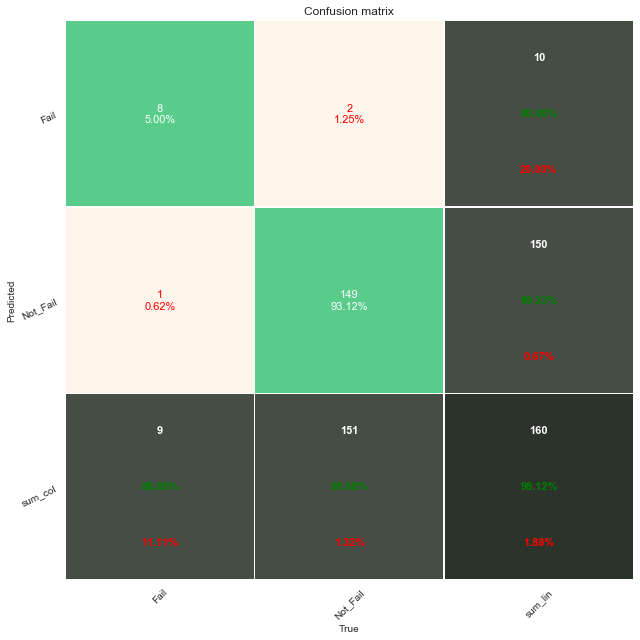

In [25]:
plot_confusion_matrix_from_data(y_test.values, final_predictions, columns=['Fail','Not_Fail'], annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[2,2], show_null_values=0, pred_val_axis='lin')

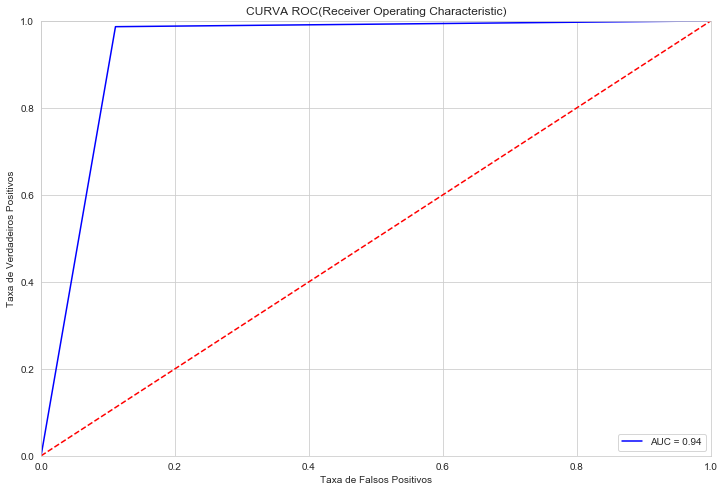

In [26]:
fpr, tpr, threshold = roc_curve(y_test.values, final_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('CURVA ROC(Receiver Operating Characteristic)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.xlabel('Taxa de Falsos Positivos')
plt.show()

### O gráfico da curva ROC(Receiver Operating Characteristic) mostra a taxa de verdadeiros e falsos positivos, nos eixos y e x respectivamente, quanto mais próximo de 1 for a área sob a curva, melhor é o modelo, o modelo otimizado conseguiu atingir uma pontuação de AUC=0.94.

## CONCLUSÃO: O Algoritimo após ser otimizado conseguiu atingir 98.125% de acertos em 4 métricas de avaliação: acurácia, precisão, recall(sensibilidade) e fBscore(B=5), cometendo somente 3 erros em todo conjunto de testes (160 amostras): 1 falso positivo e 2 falsos negativos, conseguindo detectar com grande precisão quando as falhas irão ocorrer.